## General information

This is an unique competition: the first Kaggle competition with GAN! I have trained GANs only while going through courses, so I'm excited to try this!

![](https://i.dailymail.co.uk/1/2018/10/04/17/4767130-6240719-A_Google_AI_has_created_incredibly_photo_like_images_of_animals_-a-1_1538670296449.jpg)

The kernel is heavily based by this official tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip
/kaggle/input/images/image_02460.png
/kaggle/input/images/image_04551.png
/kaggle/input/images/image_01236.png
/kaggle/input/images/image_04281.png
/kaggle/input/images/image_00907.png
/kaggle/input/images/image_02550.png
/kaggle/input/images/image_09606.png
/kaggle/input/images/image_04180.png
/kaggle/input/images/image_04897.png
/kaggle/input/images/image_04449.png
/kaggle/input/images/image_07391.png
/kaggle/input/images/image_06602.png
/kaggle/input/images/image_05371.png
/kaggle/input/images/image_02170.png
/kaggle/input/images/image_06118.png
/kaggle/input/images/image_03186.png
/kaggle/input/images/image_09449.png
/kaggle/input/images/image_01557.png
/kaggle/input/images/image_02223.png
/kaggle/input/images/image_05437.png
/kaggle/input/images/image_09069.png
/kaggle/input/images/image_02625.png
/kaggle/input/images/image_07351.png
/kaggle/input/images/image_07317.png
/kaggle/inpu

In [14]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.utils import save_image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

## Data overview

In [16]:
import zipfile
import os

# Paths to ZIP files
dogs_zip_path = '/kaggle/input/generative-dog-images/all-dogs.zip'
annotation_zip_path = '/kaggle/input/generative-dog-images/Annotation.zip'

# Extract files
extract_path = '/kaggle/working/all-dogs-extracted'
with zipfile.ZipFile(dogs_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(os.listdir(extract_path))


['all-dogs']


In [17]:
print(os.listdir('/kaggle/working/all-dogs-extracted'))


['all-dogs']


In [18]:
len(os.listdir('/kaggle/working/all-dogs-extracted'))


1

We have ~20k images in train set, we'll train on them.

In [19]:
# Setting parameters
dataroot = "/kaggle/working/all-dogs-extracted"
workers = 2

batch_size = 128
image_size = 64

# Number of channels
nc = 3
# Latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 30
# Learning rate for optimizers
lr = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.3
ngpu = 1

## Preparing data

In [20]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.RandomHorizontalFlip(),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

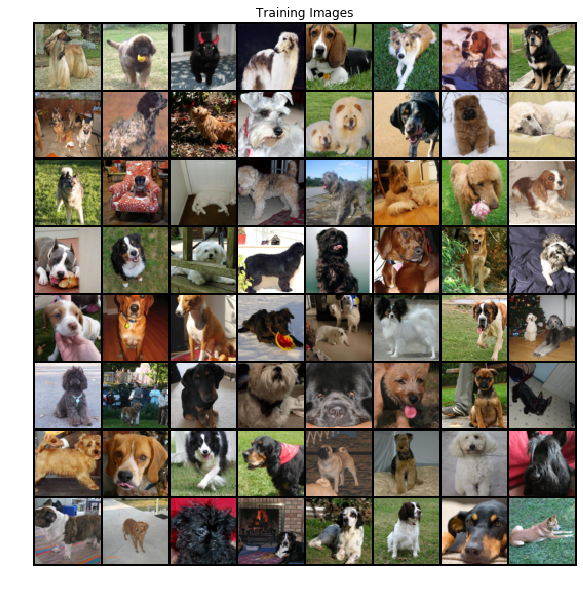

In [21]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images");
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

We have these nice images. Interesting what will be generated based on them...

In the DCGAN paper the authors wrote that all model weights should be randomly initialized from a Normal distribution with mean=0, stdev=0.02. Let's do this!

In [26]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## DCGAN architecture


In [27]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)
    

netG = Generator(ngpu).to(device);
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [28]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
netD = Discriminator(ngpu).to(device);
netD.apply(weights_init);

BCE loss is commonly used in such neural nets.

In [29]:
# Initialize BCELoss function
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
scheduler = ReduceLROnPlateau(optimizerD, factor=0.5, patience=2)
scheduler = StepLR(optimizerD, gamma=0.5, step_size=8)

## Model training

In [30]:
# # Training Loop

# # Lists to keep track of progress

# G_losses = []
# D_losses = []
# iters = 0

# valid_loss_min = np.Inf
# patience = 5
# # current number of epochs, where validation loss didn't increase
# p = 0
# # whether training should be stopped
# stop = False


# print("Starting Training Loop...")
# # For each epoch
# for epoch in range(num_epochs):
#     # For each batch in the dataloader
#     for i, data in enumerate(dataloader, 0):

#         ## Train with all-real batch
#         netD.zero_grad()
#         # Format batch
#         real_cpu = data[0].to(device)
#         b_size = real_cpu.size(0)
#         label = torch.full((b_size,), real_label, device=device)
#         # Forward pass real batch through D
#         output = netD(real_cpu).view(-1)
#         # Calculate loss on all-real batch
#         errD_real = criterion(output, label)
#         # Calculate gradients for D in backward pass
#         errD_real.backward()
#         D_x = output.mean().item()

#         ## Train with all-fake batch
#         # Generate batch of latent vectors
#         noise = torch.randn(b_size, nz, 1, 1, device=device)
#         # Generate fake image batch with G
#         fake = netG(noise)
#         label.fill_(fake_label)
#         # Classify all fake batch with D
#         output = netD(fake.detach()).view(-1)
#         # Calculate D's loss on the all-fake batch
#         errD_fake = criterion(output, label)
#         # Calculate the gradients for this batch
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         # Add the gradients from the all-real and all-fake batches
#         errD = errD_real + errD_fake
#         # Update D
#         optimizerD.step()

#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         # Since we just updated D, perform another forward pass of all-fake batch through D
#         output = netD(fake).view(-1)
#         # Calculate G's loss based on this output
#         errG = criterion(output, label)
#         # Calculate gradients for G
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         # Update G
#         optimizerG.step()

#         # Save Losses for plotting later
#         G_losses.append(errG.item())
#         D_losses.append(errD.item())

#         iters += 1
#     scheduler.step(errD.item())
    
#     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#           % (epoch, num_epochs, i, len(dataloader),
#              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
# #     loss = errG.item()
# #     if loss <= valid_loss_min:
# #         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
# #         valid_loss_min,
# #         loss))
# #         torch.save(netD.state_dict(), 'model.pt')
# #         valid_loss_min = loss
# #         p = 0

# #     # check if validation loss didn't improve
# #     if loss > valid_loss_min:
# #         p += 1
# #         print(f'{p} epochs of increasing loss')
# #         if p > patience:
# #             print('Stopping training')
# #             stop = True
# #             break        
            
# #     if stop:
# #         break

In [36]:
# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0

# Initialize the minimum validation loss
valid_loss_min = np.Inf

# Define patience for early stopping
patience = 5
p = 0
stop = False

# Directory to save models
if not os.path.exists('models'):
    os.mkdir('models')

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ## Train Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass with real images
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Forward pass with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Combine losses and update Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        ## Train Generator
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    # Step the learning rate scheduler
    scheduler.step(errD.item())

    # Print training progress
    print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch + 1, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save models if the validation loss decreases
    #loss = errD.item()  # Using Discriminator loss as validation metric
    # if loss <= valid_loss_min:
    #     print('Validation loss decreased ({:.6f} --> {:.6f}). Saving models...'.format(
    #         valid_loss_min, loss))
    #     torch.save(netG.state_dict(), os.path.join('models', 'generator.pt'))
    #     torch.save(netD.state_dict(), os.path.join('models', 'discriminator.pt'))
    #     valid_loss_min = loss
    #     p = 0
    # else:
    #     p += 1
    #     print(f'{p} epochs of increasing loss')
    #     if p > patience:
    #         print('Stopping training due to early stopping...')
    #         stop = True
    #         break

    # if stop:
    #     break

# Save final models at the end of training
torch.save(netG.state_dict(), os.path.join('models', 'final_generator.pt'))
torch.save(netD.state_dict(), os.path.join('models', 'final_discriminator.pt'))
print("Training completed. Final models saved.")


Starting Training Loop...
[1/30]	Loss_D: 0.2773	Loss_G: 5.1258	D(x): 0.9502	D(G(z)): 0.1871 / 0.0087
[2/30]	Loss_D: 0.6861	Loss_G: 1.0550	D(x): 0.5771	D(G(z)): 0.0501 / 0.4177
[3/30]	Loss_D: 0.4722	Loss_G: 1.8473	D(x): 0.7171	D(G(z)): 0.0924 / 0.1920
[4/30]	Loss_D: 0.4883	Loss_G: 3.4312	D(x): 0.8299	D(G(z)): 0.2306 / 0.0404
[5/30]	Loss_D: 1.0556	Loss_G: 5.4631	D(x): 0.9485	D(G(z)): 0.5701 / 0.0065
[6/30]	Loss_D: 1.0381	Loss_G: 5.5125	D(x): 0.9570	D(G(z)): 0.5750 / 0.0061
[7/30]	Loss_D: 0.2967	Loss_G: 3.2514	D(x): 0.8773	D(G(z)): 0.1392 / 0.0520
[8/30]	Loss_D: 0.3054	Loss_G: 3.0299	D(x): 0.8675	D(G(z)): 0.1390 / 0.0631
[9/30]	Loss_D: 0.5261	Loss_G: 3.7363	D(x): 0.8165	D(G(z)): 0.2504 / 0.0313
[10/30]	Loss_D: 0.6683	Loss_G: 2.1329	D(x): 0.6772	D(G(z)): 0.1956 / 0.1442
[11/30]	Loss_D: 0.3713	Loss_G: 3.1982	D(x): 0.8823	D(G(z)): 0.1946 / 0.0526
[12/30]	Loss_D: 0.3427	Loss_G: 2.8936	D(x): 0.8079	D(G(z)): 0.0942 / 0.0768
[13/30]	Loss_D: 0.5084	Loss_G: 4.5296	D(x): 0.9332	D(G(z)): 0.3178 / 0.

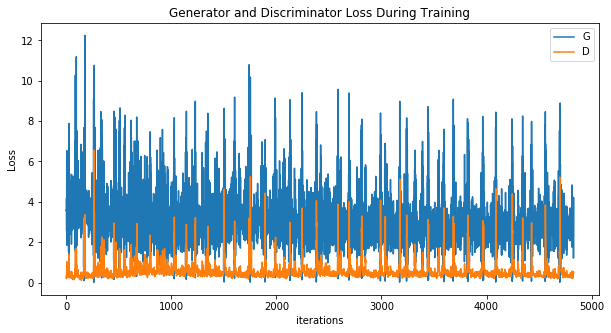

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Predicting

In [39]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'

Let's have a look at the results!

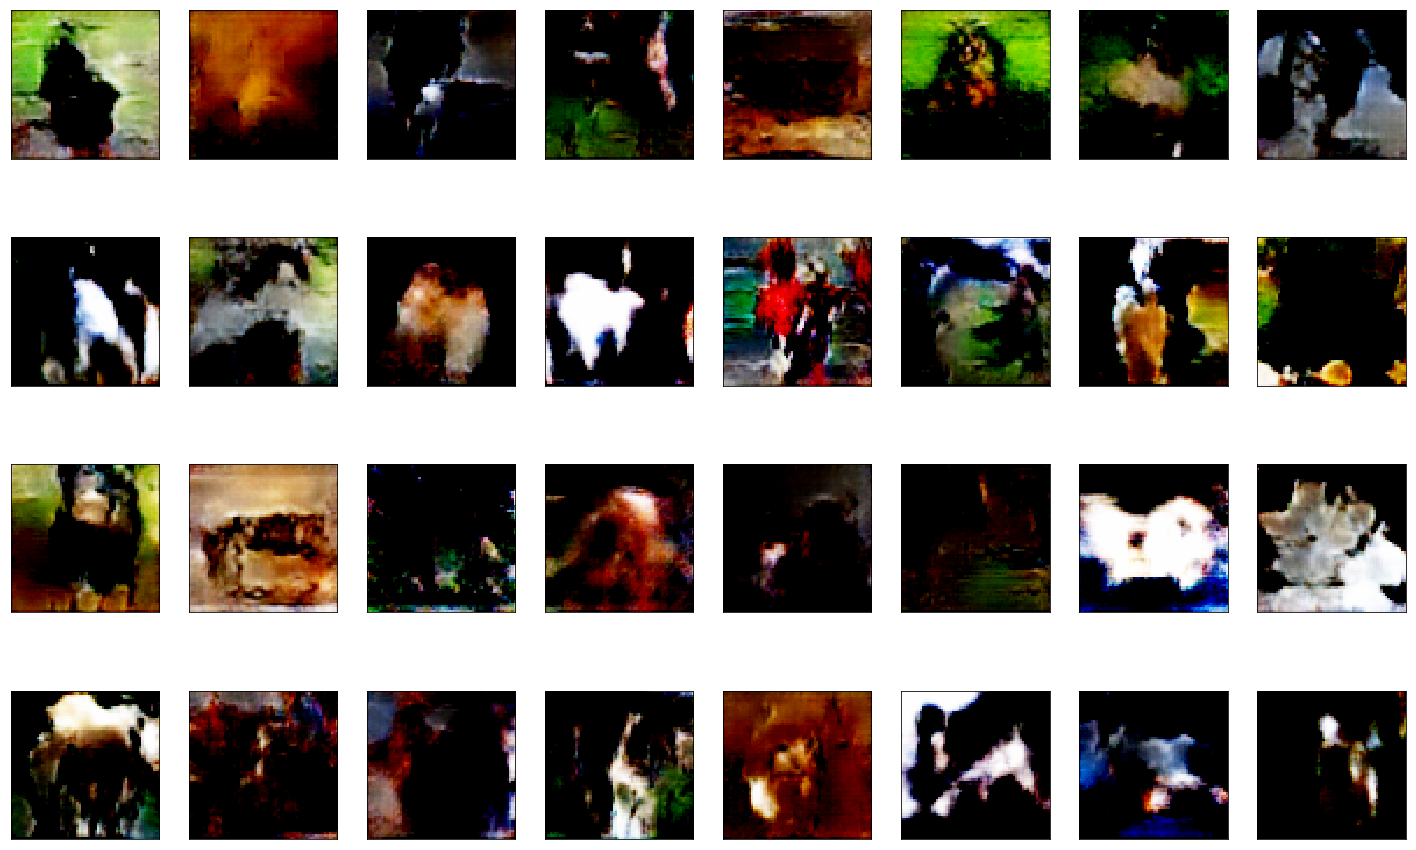

In [40]:
fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, j in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(j)

In [42]:
# import os
# import torch
# import torchvision.transforms as transforms
# from torchvision.models import inception_v3
# from scipy.stats import entropy
# import numpy as np
# from torchvision.utils import save_image
# import shutil
# from PIL import Image

# # Create the output directory if it doesn't exist
# if not os.path.exists('../output_images'):
#     os.mkdir('../output_images')

# # Generate Images
# im_batch_size = 50
# n_images = 10000  # Total images to generate
# for i_batch in range(0, n_images, im_batch_size):
#     gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
#     gen_images = netG(gen_z)
#     images = gen_images.to("cpu").clone().detach()
#     images = images.numpy().transpose(0, 2, 3, 1)
#     for i_image in range(gen_images.size(0)):
#         save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

# # Zip the images for download
# shutil.make_archive('images', 'zip', '../output_images')

# # Transform for InceptionV3
# transform = transforms.Compose([
#     transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# # # Load InceptionV3 model
# # inception_model = inception_v3(pretrained=True, transform_input=False).eval().to(device)
# state_dict = torch.load('/kaggle/input/inception-v3/pytorch/default/1/inception_v3_google-1a9a5a14.pth')
# inception_model = inception_v3(pretrained=False).eval().to(device)
# inception_model.load_state_dict(state_dict)

# def calculate_inception_score(image_dir, batch_size=32, splits=10):
#     """
#     Calculate Inception Score for images in a directory.
#     """
#     # Load images from the directory
#     image_list = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]
    
#     preds = []
#     for i in range(0, len(image_list), batch_size):
#         batch_files = image_list[i:i + batch_size]
#         batch_images = torch.stack([transform(Image.open(f)) for f in batch_files]).to(device)
#         with torch.no_grad():
#             pred = inception_model(batch_images)
#             preds.append(torch.nn.functional.softmax(pred, dim=1).cpu().numpy())

#     preds = np.concatenate(preds, axis=0)

#     # Split the predictions into groups and calculate IS
#     split_scores = []
#     for k in range(splits):
#         part = preds[k * (len(preds) // splits): (k+1) * (len(preds) // splits), :]
#         py = np.mean(part, axis=0)  # Marginal distribution
#         scores = [entropy(pyx, py) for pyx in part]
#         split_scores.append(np.exp(np.mean(scores)))

#     return np.mean(split_scores), np.std(split_scores)

# # Calculate the IS score for the generated images
# image_dir = '../output_images'
# mean_is, std_is = calculate_inception_score(image_dir)

# print(f"Inception Score: Mean = {mean_is}, Std = {std_is}")


Inception Score: Mean = 2.8045246601104736, Std = 0.03415258601307869


In [2]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision.models as models

# Load a pre-trained model (e.g., ResNet18 for TinyImageNet)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 200)  # Adjust for TinyImageNet

# Define a pruning function
def apply_pruning(model, amount=0.3):
    """
    Apply global pruning to the entire model.
    """
    parameters_to_prune = []
    
    # Select layers to prune
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((module, 'weight'))

    # Apply global pruning
    prune.global_unstructured(
        parameters_to_prune, 
        pruning_method=prune.L1Unstructured, 
        amount=amount
    )
    return model

# Apply pruning
pruned_model = apply_pruning(model, amount=0.4)

# Check sparsity
def check_sparsity(model):
    total_params = 0
    zero_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            total_params += module.weight.nelement()
            zero_params += torch.sum(module.weight == 0).item()

    sparsity = 100.0 * zero_params / total_params
    print(f"Global Model Sparsity: {sparsity:.2f}%")

check_sparsity(pruned_model)


Global Model Sparsity: 40.12%


In [43]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from scipy.stats import entropy
import numpy as np
from torchvision.utils import save_image
from PIL import Image
import shutil

# Create the output directory if it doesn't exist
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')

# Generate Images
im_batch_size = 50
n_images = 10000  # Total images to generate
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))

# Zip the images for download
shutil.make_archive('images', 'zip', '../output_images')

# Transform for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load InceptionV3 model
state_dict = torch.load('/kaggle/input/inception-v3/pytorch/default/1/inception_v3_google-1a9a5a14.pth')
inception_model = inception_v3(pretrained=False).eval().to(device)
inception_model.load_state_dict(state_dict)

def calculate_inception_score(image_dir, batch_size=32, splits=10, save_scores=True):
    """
    Calculate Inception Score for images in a directory and optionally save scores for each image.
    """
    # Load images from the directory
    image_list = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]
    
    preds = []
    image_scores = {}
    for i in range(0, len(image_list), batch_size):
        batch_files = image_list[i:i + batch_size]
        batch_images = torch.stack([transform(Image.open(f)) for f in batch_files]).to(device)
        with torch.no_grad():
            pred = inception_model(batch_images)
            pred_softmax = torch.nn.functional.softmax(pred, dim=1).cpu().numpy()
            preds.append(pred_softmax)

        # Save individual scores for each image if needed
        if save_scores:
            for img_path, pred_score in zip(batch_files, pred_softmax):
                img_name = os.path.basename(img_path)
                image_scores[img_name] = pred_score

    preds = np.concatenate(preds, axis=0)

    # Split the predictions into groups and calculate IS
    split_scores = []
    for k in range(splits):
        part = preds[k * (len(preds) // splits): (k+1) * (len(preds) // splits), :]
        py = np.mean(part, axis=0)  # Marginal distribution
        scores = [entropy(pyx, py) for pyx in part]
        split_scores.append(np.exp(np.mean(scores)))

    # Save individual image scores to a file
    if save_scores:
        with open("individual_image_scores.txt", "w") as f:
            for img_name, score in image_scores.items():
                f.write(f"{img_name}: {score.tolist()}\n")

    return np.mean(split_scores), np.std(split_scores)

# Calculate the IS score for the generated images
image_dir = '../output_images'
mean_is, std_is = calculate_inception_score(image_dir)

print(f"Inception Score: Mean = {mean_is}, Std = {std_is}")


Inception Score: Mean = 2.829524517059326, Std = 0.04190193861722946


In [1]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from PIL import Image

# Load InceptionV3 model
state_dict = torch.load('/kaggle/input/inception-v3/pytorch/default/1/inception_v3_google-1a9a5a14.pth')
inception_model = inception_v3(pretrained=False).eval().to(device)
inception_model.load_state_dict(state_dict)

# Image transform for InceptionV3
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def calculate_activation_statistics(image_dir, model, batch_size=32):
    """
    Compute activations for all images in a directory.
    """
    image_list = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
    activations = []

    for i in range(0, len(image_list), batch_size):
        batch_files = image_list[i:i + batch_size]
        batch_images = torch.stack([transform(Image.open(f)) for f in batch_files]).to(device)
        with torch.no_grad():
            pred = model(batch_images)
            activations.append(pred.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)

    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2):
    """
    Calculate the FID score using activations.
    """
    diff = mu1 - mu2
    cov_mean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    fid_score = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * cov_mean)
    return fid_score

# Directories for real and generated images
real_images_dir = '../real_images'
generated_images_dir = '../output_images'

# Calculate statistics
mu1, sigma1 = calculate_activation_statistics(real_images_dir, inception_model)
mu2, sigma2 = calculate_activation_statistics(generated_images_dir, inception_model)

# Compute FID
fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)

print(f"FID Score: {fid_score}")


FID Score: 33.46
